In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, classification_report, silhouette_score

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [4]:
char_df = pd.read_csv('data/dd_bios_02.csv', encoding='ISO-8859-1')

char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   timestamp            2447 non-null   object
 1   character_name       3447 non-null   object
 2   character_species    3447 non-null   object
 3   character_class      3447 non-null   object
 4   character_backstory  3343 non-null   object
dtypes: object(5)
memory usage: 134.8+ KB


In [5]:
char_df = char_df.drop(columns=['timestamp'])


In [6]:
char_df.head()

,character_name,character_species,character_class,character_backstory
0,Erryt,Aarakocra,Ranger,"Erryt, a 7 year-old Aarakocra with golden plum..."
1,Katyusha,Aarakocra,Cleric,Real name Erryt\n\nLives in fantasy Soviet Uni...
2,Surkiikri,Aarakocra,Monk,Surkiikri was firstborn of the ruling family o...
3,Azriel,Aasamar,Paladin,He was raised the isles in a family of nobles ...
4,Azophyr,Aasimar,Paladin,Hi... I'm Azophyr. I'm a fallen aasimar devoti...


In [7]:
char_df = char_df.dropna()

In [8]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3343 entries, 0 to 3446
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   character_name       3343 non-null   object
 1   character_species    3343 non-null   object
 2   character_class      3343 non-null   object
 3   character_backstory  3343 non-null   object
dtypes: object(4)
memory usage: 130.6+ KB


In [9]:
char_df.character_species.unique()

array(['Aarakocra', 'Aasamar', 'Aasimar', 'aasimar', 'Alien', 'Android',
       'Anthropomorphic Cockroach', 'Aquatic Half-Elf', 'Beeforged',
       'Birali (homebrew, sort of like a cat-folk)',
       'Birali turned back to Human', 'Birdfolk', 'Blue Dragonborn',
       'BugBear', 'Cambion', 'Catfolk', 'Catgirl', 'Celestial',
       'Changeling', 'Copper Dragonborn', 'Dark Elf', 'dark elf',
       'Dark elf', 'Dark Elf/Human', 'Deep Gnome', 'Demon', 'Dragonborn',
       'Drow', 'drow', 'Drow Elf', 'Drow elf', 'Dwarf', 'dwarf',
       'Earth Genasi', 'Eladrin', 'Elan', 'Elf', 'elf', 'Elf (Drow)',
       'Elf (Wood)', 'Fey Corgi', 'Feyblood', 'Fire genasi',
       'Forest gnome', 'Forest Gnome', 'genasi', 'Genasi',
       'Ghostwise Halfling', 'Ghoul Medusa', 'Githyanki', 'Gnoll',
       'Gnome', 'gnome', 'goblin', 'Goblin', 'Goliath', 'goliath',
       'Grey Elf', 'Hafling', 'Half Cat folk/ Half Elf', 'Half drow',
       "Half dwarf, half elf/orc (don't question it)", 'Half Elf',
      

In [10]:
# Convert all values in the 'character_species' and 'character_class' column to lowercase
char_df['character_species'] = char_df['character_species'].str.lower()
char_df['character_class'] = char_df['character_class'].str.lower()


# Verify the change
char_df['character_species'].unique()

array(['aarakocra', 'aasamar', 'aasimar', 'alien', 'android',
       'anthropomorphic cockroach', 'aquatic half-elf', 'beeforged',
       'birali (homebrew, sort of like a cat-folk)',
       'birali turned back to human', 'birdfolk', 'blue dragonborn',
       'bugbear', 'cambion', 'catfolk', 'catgirl', 'celestial',
       'changeling', 'copper dragonborn', 'dark elf', 'dark elf/human',
       'deep gnome', 'demon', 'dragonborn', 'drow', 'drow elf', 'dwarf',
       'earth genasi', 'eladrin', 'elan', 'elf', 'elf (drow)',
       'elf (wood)', 'fey corgi', 'feyblood', 'fire genasi',
       'forest gnome', 'genasi', 'ghostwise halfling', 'ghoul medusa',
       'githyanki', 'gnoll', 'gnome', 'goblin', 'goliath', 'grey elf',
       'hafling', 'half cat folk/ half elf', 'half drow',
       "half dwarf, half elf/orc (don't question it)", 'half elf',
       'half orc', 'half-dragon half-elf', 'half-drow',
       'half-dwarf / half-ogre', 'half-elf', 'half-elf (drow)',
       'half-orc', 'half-or

In [11]:
def replace_string_in_column(df, column, old_string, new_string):
    """
    Replaces occurrences of a specific string in a column with a new string.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column (str): The column name where the replacement should happen.
    old_string (str): The string to search for.
    new_string (str): The string to replace the old one with.

    Returns:
    pd.DataFrame: The DataFrame with the updated column.
    """
    df.loc[df[column].str.contains(old_string, case=False, na=False), column] = new_string
    return df

In [12]:
# We can clean up some glaring issues. There are still a lot of homebrew species, we will leave them as is. 

char_df = replace_string_in_column(char_df, 'character_species', 'aasamar', 'aasimar')
char_df = replace_string_in_column(char_df, 'character_species', 'half elf', 'half-elf')
char_df = replace_string_in_column(char_df, 'character_species', 'half drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-ord', 'half-orc')
char_df = replace_string_in_column(char_df, 'character_species', 'drow', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'drow elf', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'humam', 'human')


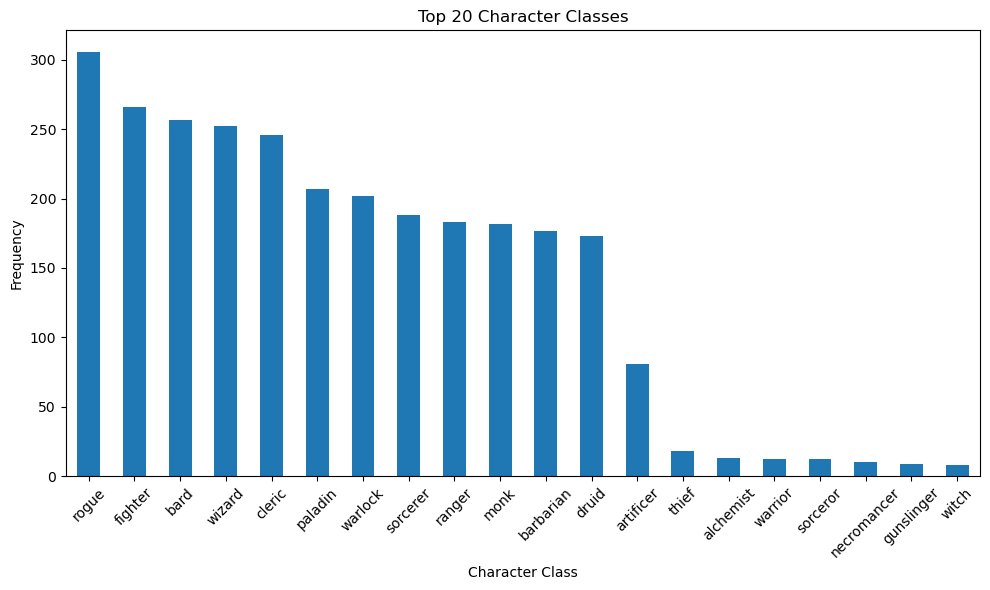

In [13]:
top_20_classes = char_df.character_class.value_counts().head(20)

# Create the plot
plt.figure(figsize=(10,6))
top_20_classes.plot(kind='bar')
plt.title('Top 20 Character Classes')
plt.xlabel('Character Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

This is a solid representation of the 5ed classes available, and a good number of other types of classes that make up this dataset. 

Let's start cleaning up the rest of the text to get ready for tokenization

In [14]:
# Function to remove non-letter characters
def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Apply the cleaning function to columns
char_df['character_species'] = char_df['character_species'].apply(clean_text)
char_df['character_name'] = char_df['character_name'].apply(clean_text)


In [15]:
# !pip install nltk

In [16]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Make sure you have stopwords and lemmatizer from NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabet characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to the backstories
char_df['cleaned_backstory'] = char_df['character_backstory'].apply(preprocess_text)

In [18]:
# Use TF-IDF to vectorize the cleaned backstories
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(char_df['cleaned_backstory'])

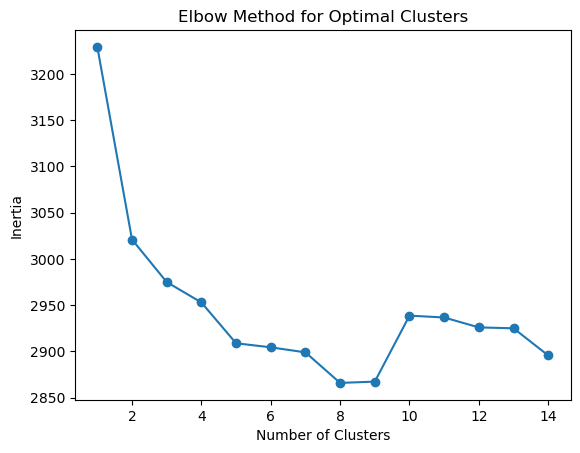

In [19]:
# Find the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In this plot, look for the "elbow" point where the inertia starts to flatten out. This suggests the optimal number of clusters.

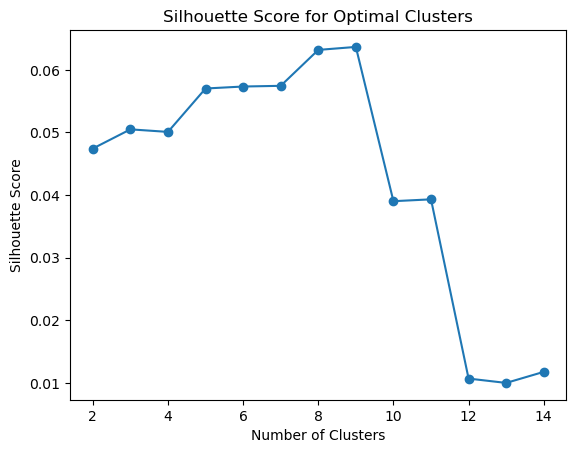

In [20]:
# Evaluate the Silhouette Score for different numbers of clusters
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the Silhouette Score
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

Choose the number of clusters that yields the highest silhouette score.

In [21]:


# Use K-Means clustering to find themes
num_clusters = 8  # Based on the silohuette score above. 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add the cluster labels as the theme category
char_df['theme_category'] = kmeans.labels_

# Examine some examples from each cluster
for cluster in range(num_clusters):
    print(f"\nCluster {cluster} examples:")
    print(char_df[char_df['theme_category'] == cluster]['character_backstory'].head(5))


Cluster 0 examples:
18     Pirates usually left Illithrian's small fishin...
69     Danger was the sole survivor of a pirate raid ...
72     I spent my early days in a Dragonborn Clan alo...
89     Chakos was born in a major city in the Underda...
102    Captain Blackfist was a captain of a mighty ve...
Name: character_backstory, dtype: object

Cluster 1 examples:
2453    Azazel Shadowdancer is a Tiefling Monk, known ...
2457    Bryn Ravenclaw is a Aasimar Bard, known for th...
2459    Cora Thorne is a Wechselkind Fighter, known fo...
2460    Elara Darkwood is a Elf Ranger, known for thei...
2461    Ithariel is a Gallus Monk, known for their unm...
Name: character_backstory, dtype: object

Cluster 2 examples:
2448    Seren, a shadow among shadows, learned the art...
2449    Cora, once a humble protector of the weak, now...
2450    Bryn Doomhammer, once a humble protector of th...
2452    Cora Stonegale, a shadow among shadows, learne...
2455    Jarin Thorne, a shadow among shadows, le

In [22]:
# Combine 'character_name', 'character_species', and 'character_class' into a single input text feature
char_df['input_text'] = char_df['character_name'] + ' ' + char_df['character_species'] + ' ' + char_df['character_class']

# Define features (X) and target (y)
X = char_df['input_text']
y = char_df['theme_category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

____

## Let's do a shotgun approach and run these features/target through a bunch of models

____

In [23]:
# Build a pipeline with TF-IDF vectorizer and a classifier (e.g., Logistic Regression)
model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=200))

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Generate a classification report
print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}")

Accuracy: 0.5994020926756353
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.85      0.90      0.87       108
           2       0.70      0.93      0.80        42
           3       0.48      0.93      0.63        14
           4       0.24      0.09      0.13        55
           5       0.38      0.85      0.52        13
           6       0.59      0.75      0.66       297
           7       0.29      0.10      0.15       125

    accuracy                           0.60       669
   macro avg       0.44      0.57      0.47       669
weighted avg       0.53      0.60      0.55       669



In [24]:
# Build the pipeline with RandomForest
model_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100))

# Train and evaluate the model
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Evaluate the Random Forest model
print(f"Accuracy (Random Forest): {accuracy_score(y_test, y_pred_rf)}")
print(f"Classification Report (Random Forest):\n{classification_report(y_test, y_pred_rf)}")

Accuracy (Random Forest): 0.4678624813153961
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      0.07      0.12        15
           1       0.41      0.92      0.56       108
           2       0.38      0.81      0.52        42
           3       0.50      0.93      0.65        14
           4       0.33      0.02      0.03        55
           5       0.28      0.69      0.40        13
           6       0.59      0.51      0.55       297
           7       0.24      0.03      0.06       125

    accuracy                           0.47       669
   macro avg       0.47      0.50      0.36       669
weighted avg       0.46      0.47      0.40       669



In [25]:
# Build the pipeline with TF-IDF and SVM
model_svm = make_pipeline(TfidfVectorizer(), LinearSVC(max_iter=1000))

# Train and evaluate the model
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

# Evaluate the SVM model
print(f"Accuracy (SVM): {accuracy_score(y_test, y_pred_svm)}")
print(f"Classification Report (SVM):\n{classification_report(y_test, y_pred_svm)}")

Accuracy (SVM): 0.5575485799701047
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.67      0.13      0.22        15
           1       0.75      0.95      0.84       108
           2       0.38      0.98      0.55        42
           3       0.50      1.00      0.67        14
           4       0.19      0.05      0.08        55
           5       0.35      0.85      0.50        13
           6       0.64      0.61      0.62       297
           7       0.30      0.15      0.20       125

    accuracy                           0.56       669
   macro avg       0.47      0.59      0.46       669
weighted avg       0.53      0.56      0.52       669



In [26]:
# Build the pipeline with TF-IDF and Gradient Boosting
model_gb = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier(n_estimators=100))

# Train and evaluate the model
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

# Evaluate the Gradient Boosting model
print(f"Accuracy (Gradient Boosting): {accuracy_score(y_test, y_pred_gb)}")
print(f"Classification Report (Gradient Boosting):\n{classification_report(y_test, y_pred_gb, )}")

Accuracy (Gradient Boosting): 0.5605381165919282
Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       1.00      0.07      0.12        15
           1       0.79      0.85      0.82       108
           2       0.33      0.90      0.48        42
           3       0.76      0.93      0.84        14
           4       0.29      0.04      0.06        55
           5       0.38      0.92      0.53        13
           6       0.58      0.72      0.64       297
           7       0.20      0.02      0.03       125

    accuracy                           0.56       669
   macro avg       0.54      0.56      0.44       669
weighted avg       0.51      0.56      0.49       669



In [27]:
# Build the pipeline with TF-IDF and Naive Bayes
model_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train and evaluate the model
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)

# Evaluate the Naive Bayes model
print(f"Accuracy (Naive Bayes): {accuracy_score(y_test, y_pred_nb)}")
print(f"Classification Report (Naive Bayes):\n{classification_report(y_test, y_pred_nb, zero_division=0)}")

Accuracy (Naive Bayes): 0.5874439461883408
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.62      0.89      0.73       108
           2       1.00      0.07      0.13        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        55
           5       0.00      0.00      0.00        13
           6       0.57      0.98      0.73       297
           7       0.67      0.02      0.03       125

    accuracy                           0.59       669
   macro avg       0.36      0.24      0.20       669
weighted avg       0.54      0.59      0.45       669



In [28]:
# Build the pipeline with TF-IDF and XGBoost
model_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier(eval_metric='mlogloss'))

# Train and evaluate the model
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the XGBoost model
print(f"Accuracy (XGBoost): {accuracy_score(y_test, y_pred_xgb)}")
print(f"Classification Report (XGBoost):\n{classification_report(y_test, y_pred_xgb)}")

Accuracy (XGBoost): 0.4828101644245142
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.45      0.91      0.60       108
           2       0.39      0.90      0.55        42
           3       0.80      0.86      0.83        14
           4       0.11      0.02      0.03        55
           5       0.32      0.92      0.48        13
           6       0.59      0.52      0.55       297
           7       0.26      0.06      0.09       125

    accuracy                           0.48       669
   macro avg       0.37      0.52      0.39       669
weighted avg       0.44      0.48      0.42       669



In [34]:
# Build the pipeline with TF-IDF and KNN
model_knn = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=8))

# Train and evaluate the model
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

# Evaluate the KNN model
print(f"Accuracy (KNN): {accuracy_score(y_test, y_pred_knn)}")
print(f"Classification Report (KNN):\n{classification_report(y_test, y_pred_knn)}")

Accuracy (KNN): 0.4857997010463378
Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.18      0.13      0.15        15
           1       0.43      0.93      0.59       108
           2       0.36      0.29      0.32        42
           3       0.12      0.07      0.09        14
           4       0.30      0.05      0.09        55
           5       0.00      0.00      0.00        13
           6       0.58      0.67      0.62       297
           7       0.27      0.06      0.10       125

    accuracy                           0.49       669
   macro avg       0.28      0.28      0.25       669
weighted avg       0.43      0.49      0.42       669

